# 6.6 Sourcing and Analyzing Time Series Data

### Contents

1. Importing libraries and data
2. Time series analysis: decomposition
3. Testing for stationarity
4. Stationarizing the King County data

### 1. Importing libraries and data

In [9]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 
import nasdaqdatalink

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [10]:
# Configure API key 

quandl.ApiConfig.api_key = 'zaW66ayuF3i9z8HDcJyp'

In [27]:
# Importing the Zillow Real Estate Data "King County Regions" variable.

quandl.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id=['99693', '99637', '99618', '99614', '99613', '99608',
    '99607', '99605', '99598', '99591', '99590', '99584', '99577', '99564', '99561', '99559', '99554', '99550', '99548',
    '99547', '99546', '99541', '99539', '99537', '99535', '99533', '99532', '99531', '99529', '99525', '99524', '99523',
    '99517', '99513', '99512', '99509', '99507', '99504', '99502', '99498', '99491'])

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99693,2023-05-31,429117.702016
1,ZSFH,99693,2023-04-30,427165.881823
2,ZSFH,99693,2023-03-31,428386.045372
3,ZSFH,99693,2023-02-28,427202.540592
4,ZSFH,99693,2023-01-31,418563.859172
...,...,...,...,...
9995,ZSFH,99513,2021-02-28,825091.000000
9996,ZSFH,99513,2021-01-31,820903.000000
9997,ZSFH,99513,2020-12-31,803892.000000


In [22]:
data.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [23]:
data.shape

(332, 1)

In [24]:
data.columns

Index(['Value'], dtype='object')

In [25]:
type(data)

pandas.core.frame.DataFrame

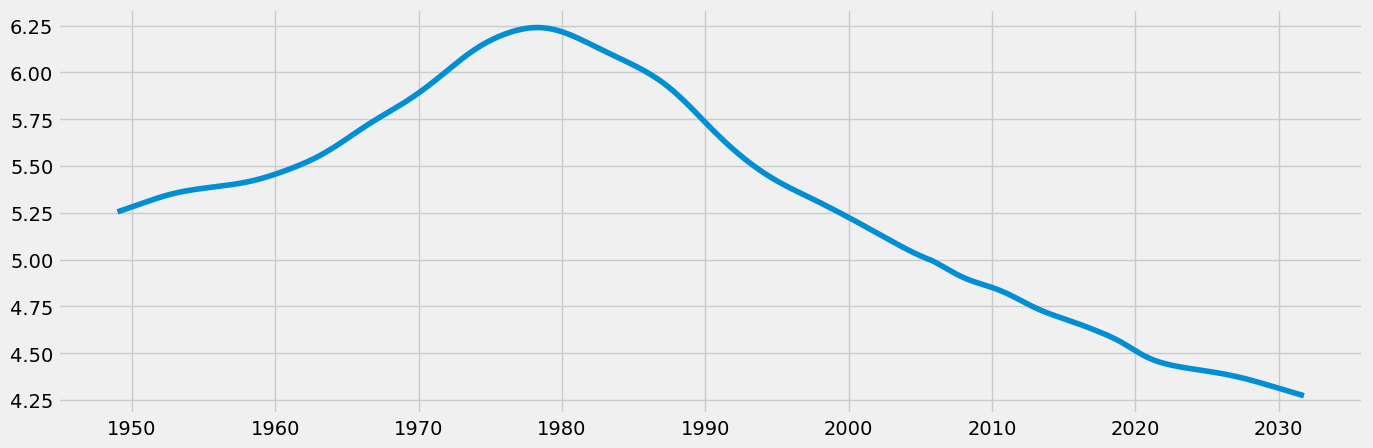

In [91]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

In [150]:
# Check for missing values.

data.isnull().sum() 

Value    0
dtype: int64

In [151]:
# Check for duplicates.

dups = data.duplicated()
dups.sum()

# No dups

0

### 2. Time-series analysis: decomposition

In [152]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [153]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

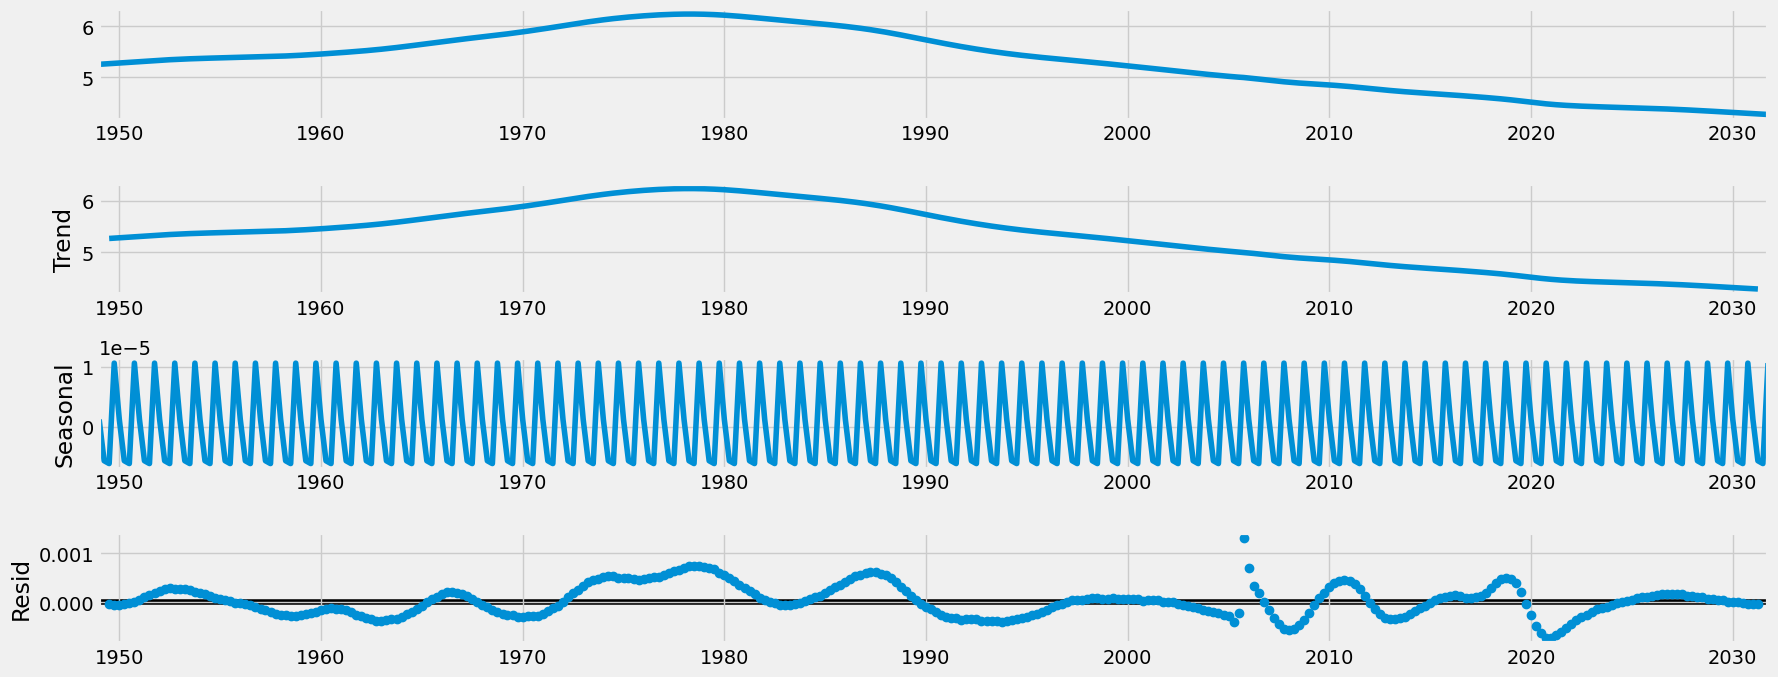

In [154]:
# Plot the separate components

decomposition.plot()
plt.show()

The level and trend appear the same. The trend gradually goes up until right before 1980 and then consistently goes on a downward trend after 1980. There are seasonal fluctuations as shown by the spikey curve that changes at a regular interval. The data also shows some noise throughout but I will not be smoothing the data in this exercise.

### 3. Testing for stationarity

#### Null hypothesis: There is a unit root.

In [160]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.352149
p-value                          0.604990
Number of Lags Used              7.000000
Number of Observations Used    324.000000
Critical Value (1%)             -3.450695
Critical Value (5%)             -2.870502
Critical Value (10%)            -2.571545
dtype: float64


#### We are not able to reject the null hypothesis because the test statistic is larger than the critical value. The test result is not significant because the p-value is not less than 0.05. In this case, using a significance level of 5%, the Critical Value (5%) has a value of -2.870502 which is small than the Test Statistic with a value of -1.352149. There is a unit root in this data and the data is non-stationary.

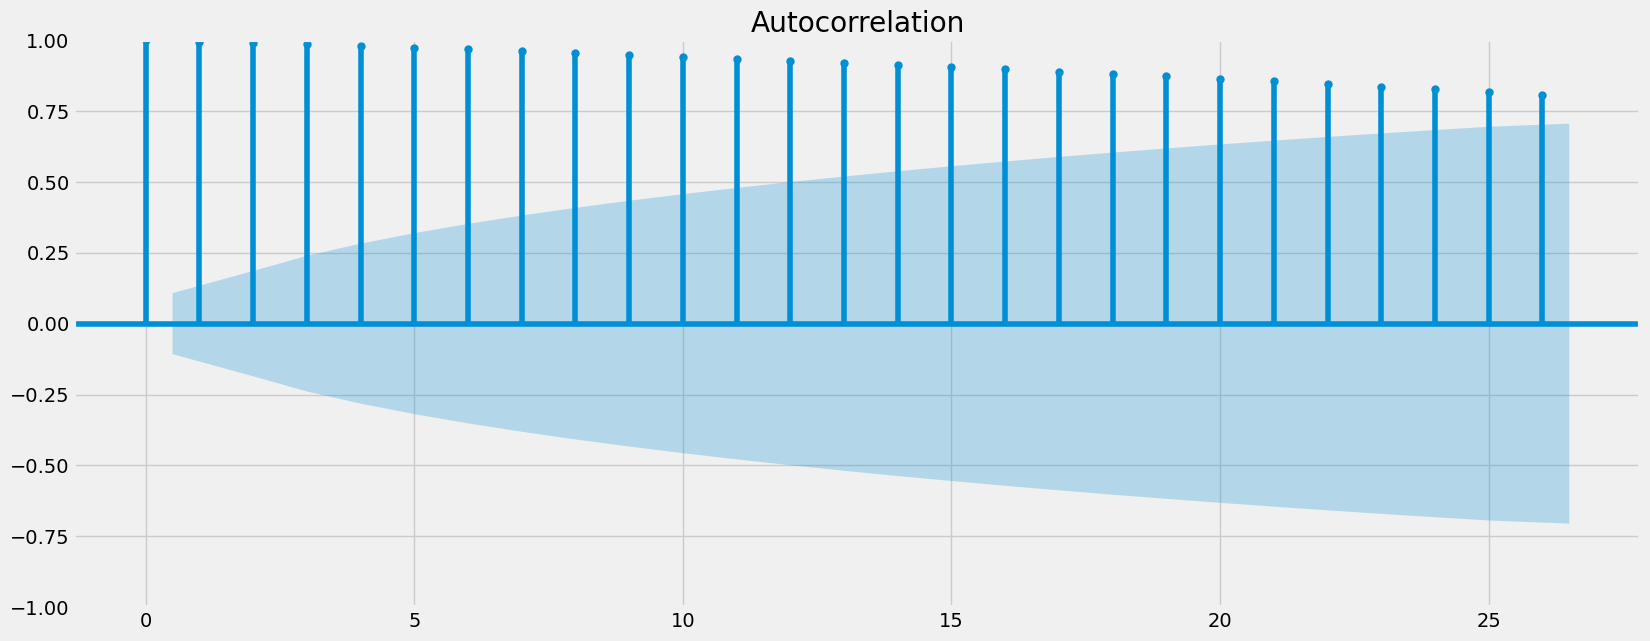

In [64]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data)
plt.show()

#### All the data are correlated with each other. All the lines go above the blue edge of the confidence interval.

### 4. Stationarizing the data

In [66]:
data_diff = data - data.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [67]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [68]:
data_diff.head()

,Value
Date,
1949-04-01,0.006463
1949-07-01,0.006497
1949-10-01,0.006551
1950-01-01,0.006618
1950-04-01,0.006684


In [69]:
data_diff.columns

Index(['Value'], dtype='object')

In [81]:
# Check for missing values (you shouldn't have any)

data_diff.isnull().sum() 

Value    0
dtype: int64

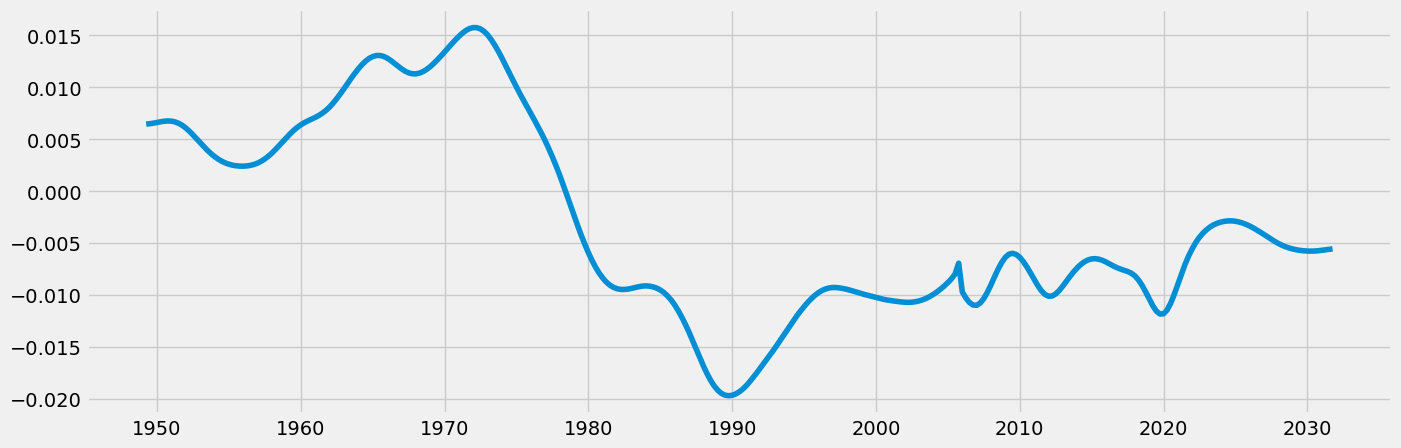

In [70]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [71]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.552187
p-value                          0.507556
Number of Lags Used              6.000000
Number of Observations Used    324.000000
Critical Value (1%)             -3.450695
Critical Value (5%)             -2.870502
Critical Value (10%)            -2.571545
dtype: float64


In [82]:
data_diff2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [84]:
data_diff2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [85]:
data_diff2.head()

,Value
Date,
1949-07-01,0.000034
1949-10-01,0.000054
1950-01-01,0.000067
1950-04-01,0.000066
1950-07-01,0.000054


In [86]:
data_diff2.columns

Index(['Value'], dtype='object')

In [87]:
# Check for missing values (you shouldn't have any)

data_diff2.isnull().sum() 

Value    0
dtype: int64

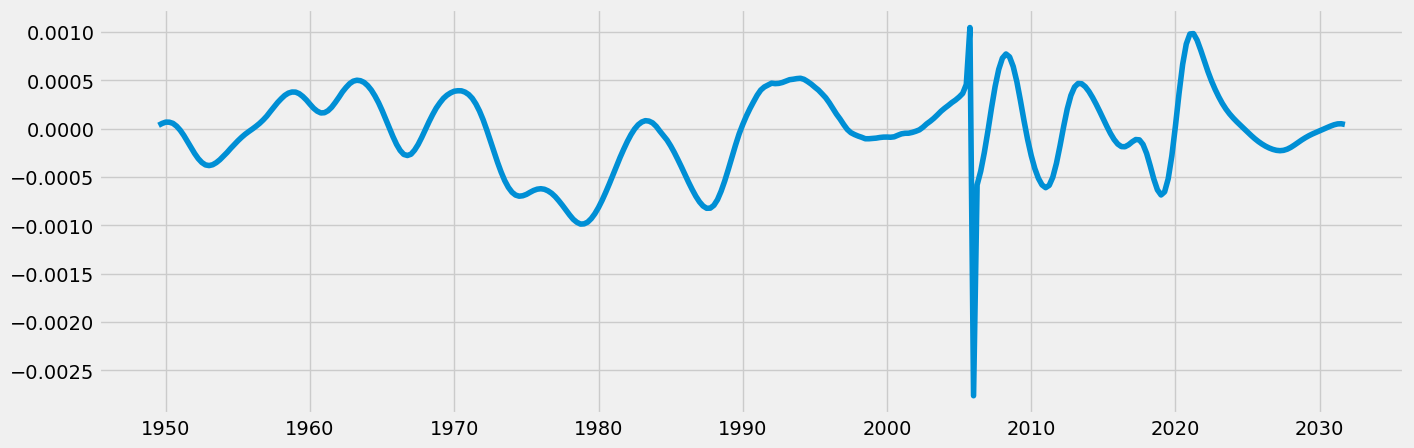

In [88]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [89]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.865427
p-value                          0.000041
Number of Lags Used              5.000000
Number of Observations Used    324.000000
Critical Value (1%)             -3.450695
Critical Value (5%)             -2.870502
Critical Value (10%)            -2.571545
dtype: float64


#### The Test Statistic is now smaller than the Critical Value at all levels with a satisfactory p-value much less than 0.5. This means we can reject the null hypothesis and consider the time series stationary.

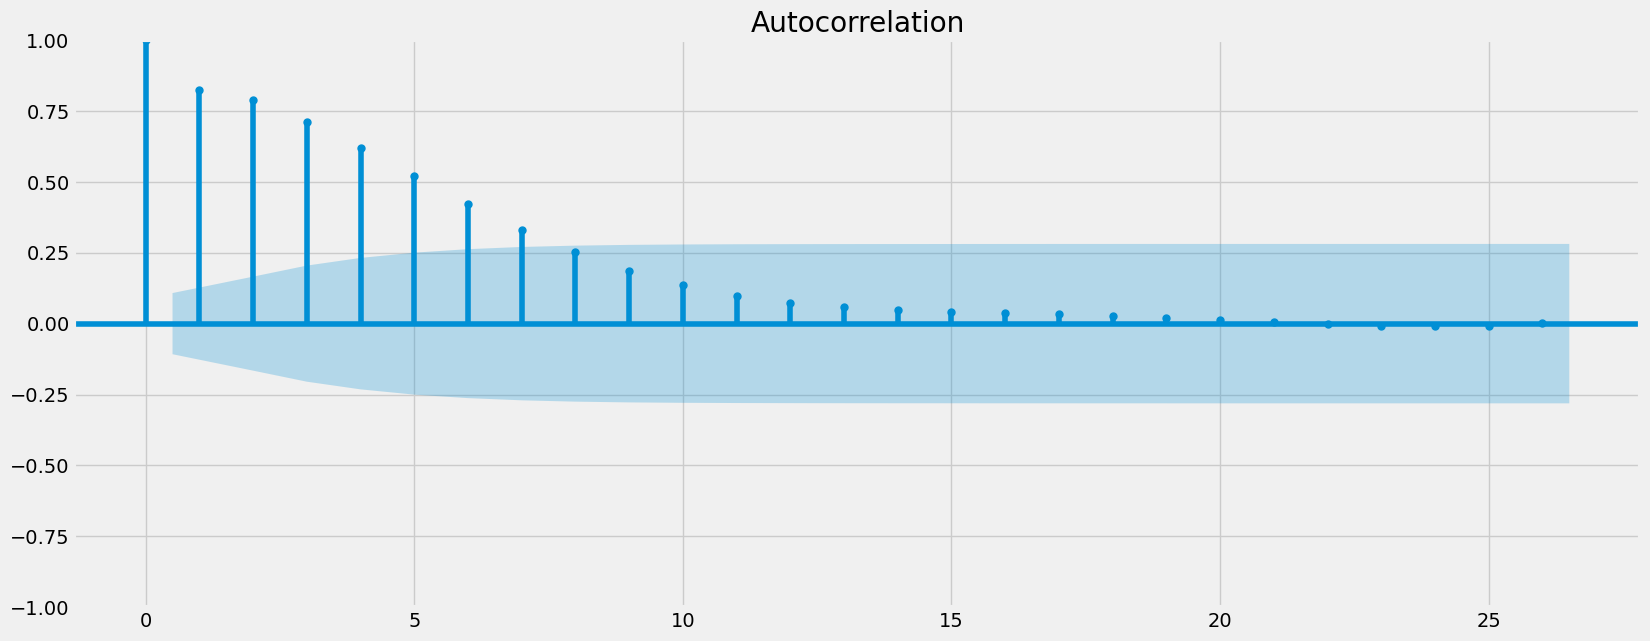

In [90]:
plot_acf(data_diff2)
plt.show()

#### The autocorrelation plot has much fewer autocorrelated terms and another round of differencing to stationarize the data is not necessary with less than 10 lags. 